# Multi-session analysis

Combined ACh and DA results in the same plot for comparison

In [1]:
%reload_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from glob import glob
import re
from datetime import datetime
from trialexp.process.folder_org.utils import build_session_info, load_and_concat_dataset, filter_sessions
from trialexp.process.group_analysis.plot_utils import plot_group_average, plot_subject_average, plot_subject_average_by_outcome, plot_subject_comparison, equal_subsample_trials
import itertools
import patchworklib as pw
import os

<Figure size 100x100 with 0 Axes>

## Load selected sessions

In [2]:
#specify the location of the by_sessions folder here
root_path = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions' #'/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions'
figure_out_path = os.path.join(root_path, 'ASAP_meeting_June2023') # '/home/MRC.OX.AC.UK/ndcn1330/ettin/Teris/DATA/ASAP_meeting_June2023'

# two pkl files are required
DA_sessions = pd.read_pickle('DA_sessions.pkl')
ACh_sessions = pd.read_pickle('ACh_sessions.pkl')

In [3]:
def get_session_path(row):
    return Path(os.path.join(root_path, row.task_name, row.session_id))


# create the path
DA_sessions['path'] = DA_sessions.apply(get_session_path, axis=1)
ACh_sessions['path'] = ACh_sessions.apply(get_session_path, axis=1)


## Read xarray datasets

In [4]:
#select the last 5 sessions from animal kms058
ds_combined_DA = load_and_concat_dataset(DA_sessions.path)
ds_combined_ACh = load_and_concat_dataset(ACh_sessions.path)

  0%|          | 0/31 [00:00<?, ?it/s]

\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions\reaching_go_spout_bar_nov22\kms063-2023-04-01-180930\processed\xr_session.nc not found! skipping
\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions\reaching_go_spout_bar_nov22\kms064-2023-02-14-115018\processed\xr_session.nc not found! skipping
Concating datasets...


  0%|          | 0/23 [00:00<?, ?it/s]

Concating datasets...


In [5]:
animal_id_DA = DA_sessions[['animal_id','session_id', 'expt_datetime']]
animal_id_ACh = ACh_sessions[['animal_id','session_id', 'expt_datetime']]

In [6]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams["legend.frameon"] = False
plt.rcParams['axes.labelsize'] = 14
if os.name =='nt':
    plt.rcParams['font.family'] = ['Arial']
elif os.name =='posix':
    plt.rcParams['font.family'] = ['Lato']


## Plot and compare group average 

In [17]:
sns.set_context('talk',font_scale=1.6)


vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

xlabels = {'hold_for_water_zscored_df_over_f': 'Time around cue onset (ms)',
          'first_bar_off_zscored_df_over_f': 'Time around first bar release (ms)',
          'first_spout_zscored_df_over_f': 'Time around spout touch (ms)',
          'last_bar_off_zscored_df_over_f': 'Time around last bar release (ms)'}

average_mode = ['equal_subsample', 'mean_of_mean']

errorbar = 'ci'
# errorbar = 'sd' # use this option for development/debug for speed


analysis_param = list(itertools.product(vars_to_plot, average_mode))

for v, mode in tqdm(list(itertools.product(vars_to_plot, average_mode))):
    
    xlabel = xlabels[v]
    
    ax1 = pw.Brick(figsize=(6,6))
    ax2 = pw.Brick(figsize=(6,6))

    plot_group_average(ds_combined_DA, animal_id_DA, v, ax=ax1, title='', errorbar=errorbar, xlabel=xlabel, average_method=mode) 
    plot_group_average(ds_combined_ACh, animal_id_ACh, v, ax=ax2, title='', errorbar=errorbar, xlabel=xlabel, average_method=mode)


    ax1.move_legend(new_loc='upper left', bbox_to_anchor=(1.05, 1.0), fontsize=34)
    ax2.move_legend(new_loc='upper left', bbox_to_anchor=(1.05, 1.0), fontsize=34)


    ax1.xaxis.label.set_size(34)
    ax1.yaxis.label.set_size(34)
    ax2.xaxis.label.set_size(34)
    ax2.yaxis.label.set_size(34)

    fig = ax2/ax1 # ACh over DA
    fig.savefig(f'figures/combined/group_average_{v}_{mode}.png', bbox_inches='tight')
    # display(fig)

  0%|          | 0/8 [00:00<?, ?it/s]

## Plot and compare individual average

In [8]:
vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

xlabels = {'hold_for_water_zscored_df_over_f': 'Time around cue onset (ms)',
          'first_bar_off_zscored_df_over_f': 'Time around first bar release (ms)',
          'first_spout_zscored_df_over_f': 'Time around spout touch (ms)',
          'last_bar_off_zscored_df_over_f': 'Time around last bar release (ms)'}

sns.set_context('talk',font_scale=1)

# vars_to_plot = ['hold_for_water_zscored_df_over_f']

errorbar = 'ci'

pw.clear() #patchworklib keep a set of global objects, need to clear them first for figure level seaborn plots


for i,v in tqdm(enumerate(vars_to_plot)):
    
    xlabel = xlabels[v]
    
    ax1 = pw.Brick(figsize=(6,6))
    ax2 = pw.Brick(figsize=(6,6))
    ax3 = pw.Brick(figsize=(6,6))
    ax4 = pw.Brick(figsize=(6,6))
    
    
    plot_subject_average_by_outcome(ds_combined_ACh, animal_id_ACh, v, trial_outcome='success', xlabel=xlabel, errorbar=errorbar, ax=ax1)
    plot_subject_average_by_outcome(ds_combined_ACh, animal_id_ACh, v, trial_outcome='aborted', xlabel=xlabel, errorbar=errorbar, ax=ax2)

    plot_subject_average_by_outcome(ds_combined_DA, animal_id_DA, v, trial_outcome='success', xlabel=xlabel, errorbar=errorbar, ax=ax3)
    plot_subject_average_by_outcome(ds_combined_DA, animal_id_DA, v, trial_outcome='aborted', xlabel=xlabel,errorbar=errorbar, ax=ax4)

    row1 = (ax1|ax2)
    row1.set_suptitle('ACh')
    
    row2 = (ax3|ax4)
    row2.set_suptitle('DA')
    
    fig = row1/row2
    
    display(fig)

    fig.savefig(f'figures/combined/subject_average_{v}.png', bbox_inches='tight')

0it [00:00, ?it/s]

KeyboardInterrupt: 

## Individual average (old method)

[]
[]


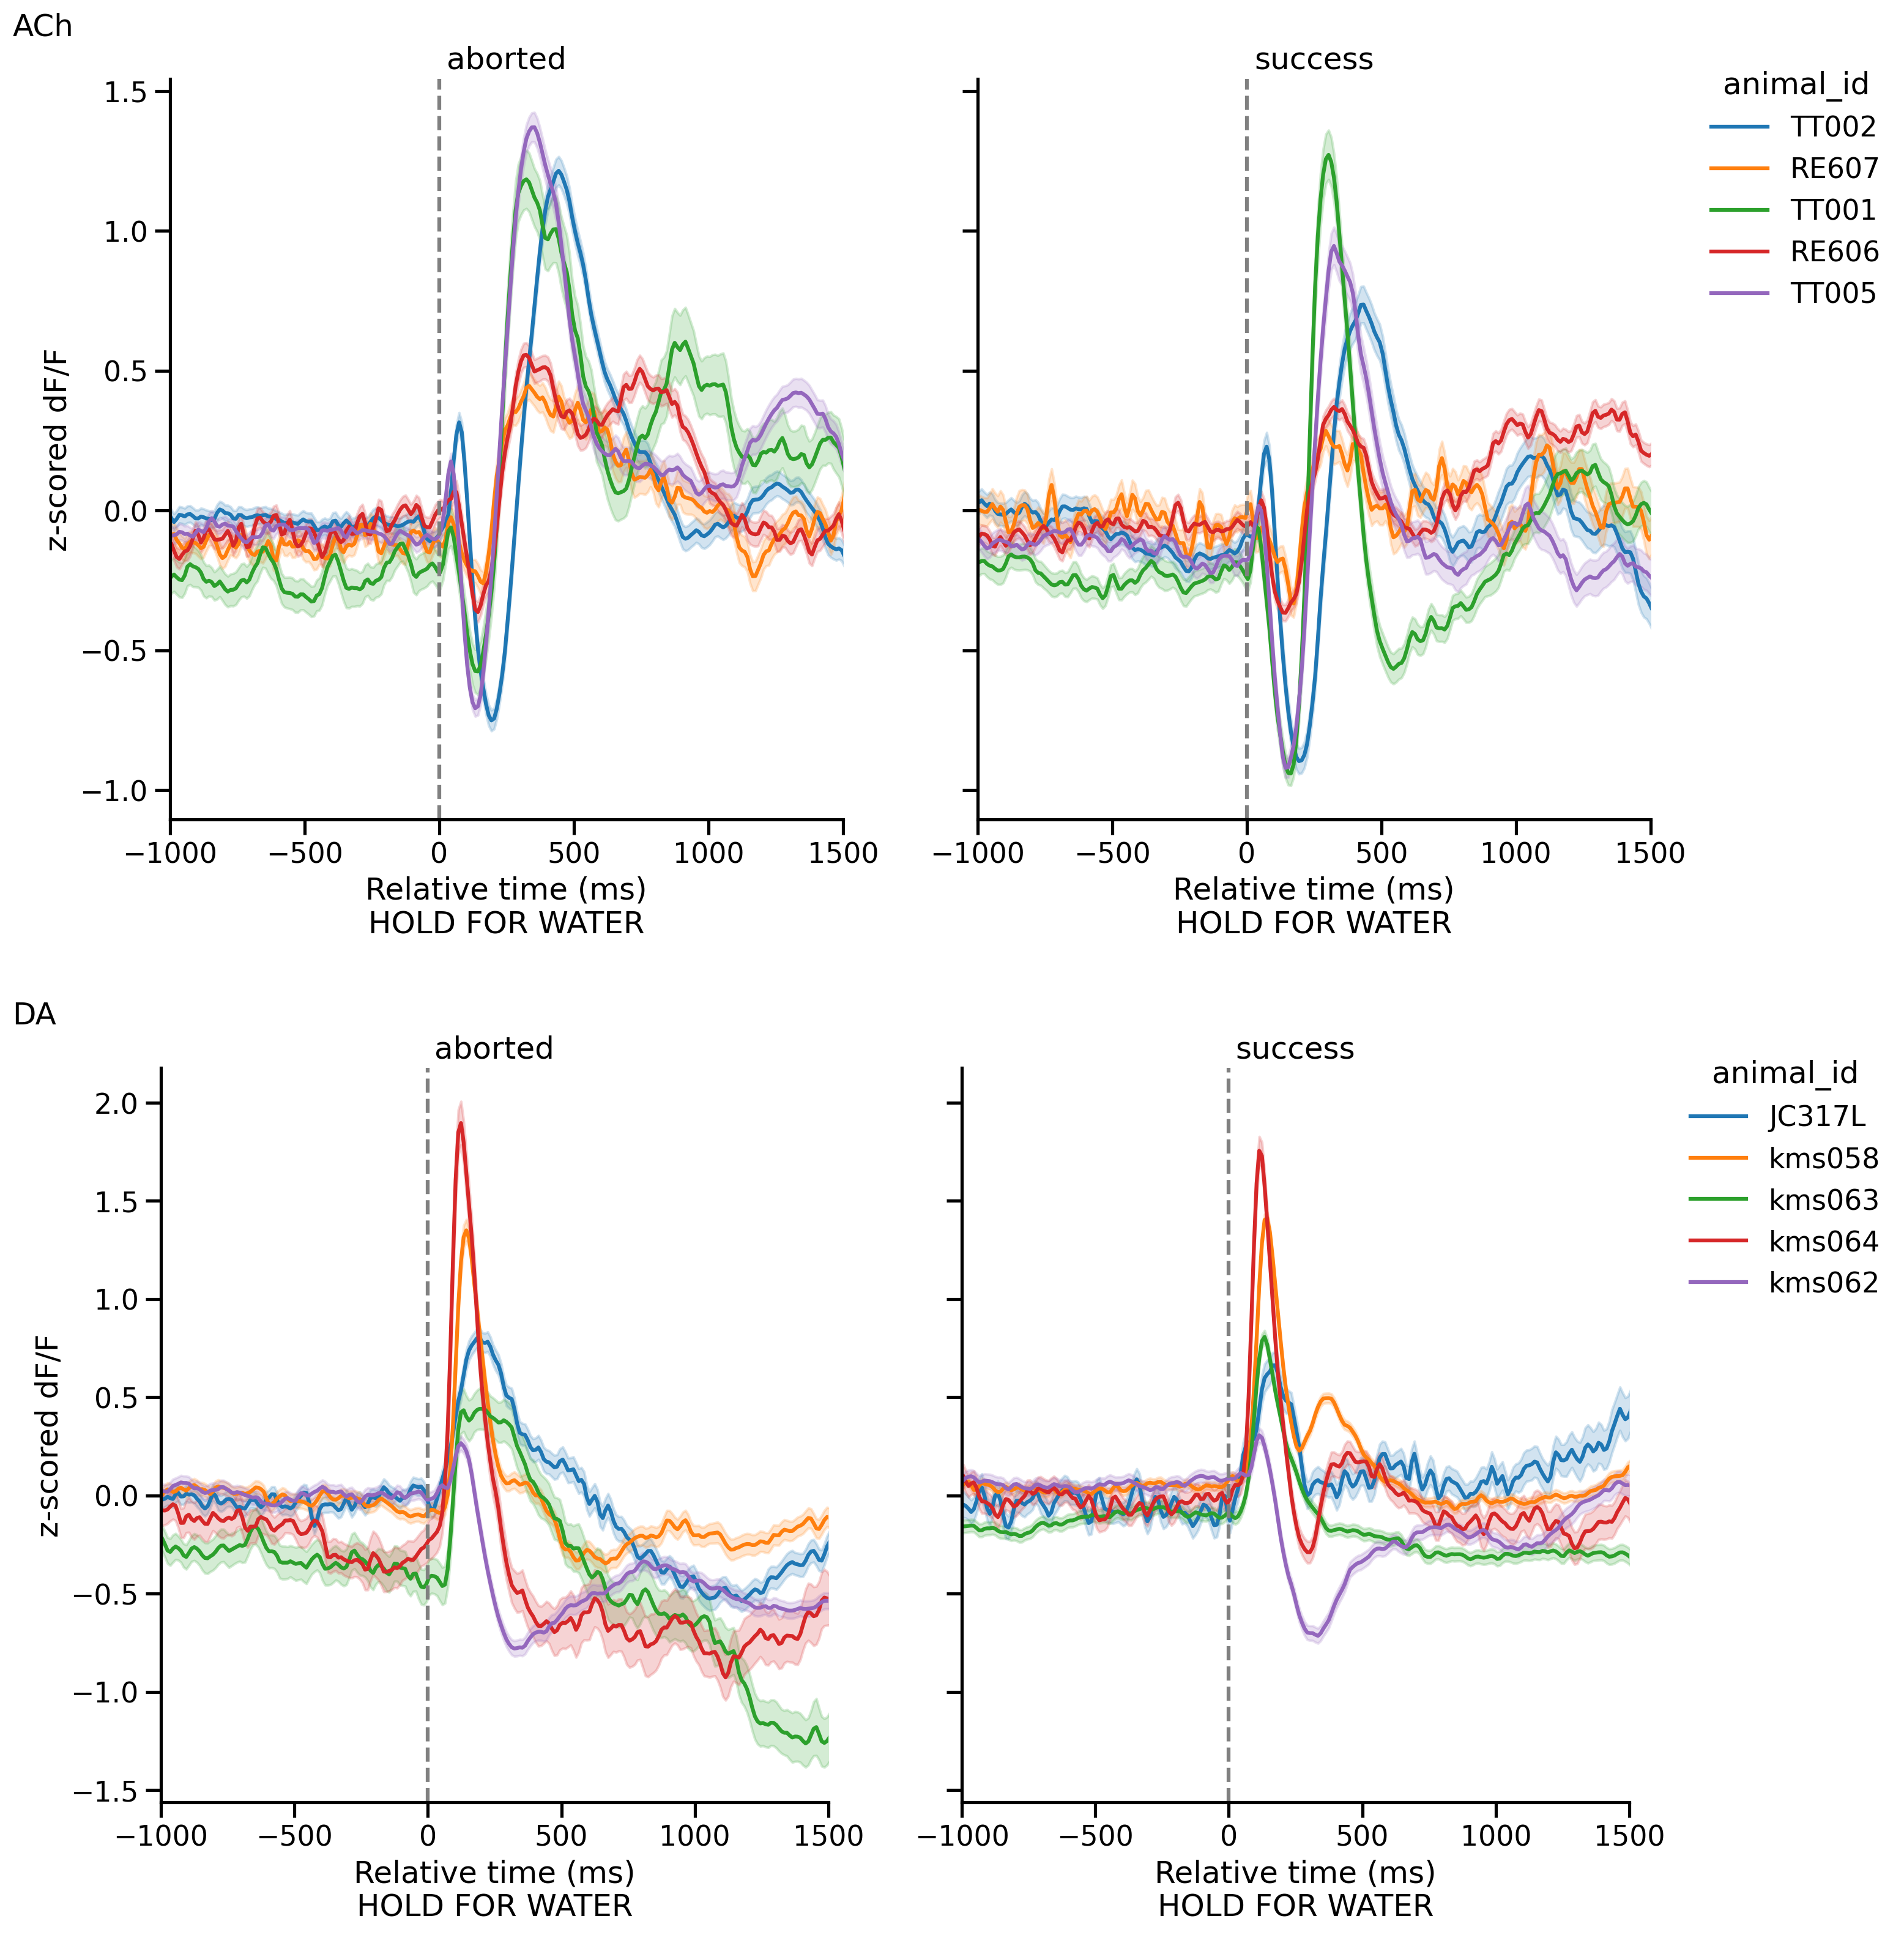

In [33]:
# vars_to_plot = ['hold_for_water_zscored_df_over_f', 
#                 'first_bar_off_zscored_df_over_f',
#                 'first_spout_zscored_df_over_f',
#                 'last_bar_off_zscored_df_over_f']

sns.set_context('talk',font_scale=1)

vars_to_plot = ['hold_for_water_zscored_df_over_f']

errorbar = 'se'

pw.clear() #patchworklib keep a set of global objects, need to clear them first
pw.overwrite_axisgrid()

for v in vars_to_plot:

    g1, fig1, df2plot = plot_subject_average(ds_combined_DA, animal_id_DA, v, errorbar=errorbar)
    g2, fig2, _ = plot_subject_average(ds_combined_ACh, animal_id_ACh, v, errorbar=errorbar)
    

    g1 = pw.load_seaborngrid(g1, label='DA',figsize=(12,6))
    g1.move_legend('upper left', bbox_to_anchor=(1,1))
    g1.case.set_title('DA', x=0, y=1)
    
    g2 = pw.load_seaborngrid(g2, label='ACh', figsize=(12, 6))
    g2.move_legend('upper left', bbox_to_anchor=(1,1))
    g2.case.set_title('ACh', x=0, y=1)

    
    g21 = g2.outline/g1.outline
    display(g21)
    # fig.savefig(f'figures/combined/subject_average_{v}_{mode}.png', bbox_inches='tight')

In [29]:
df = df2plot.groupby(['animal_id','trial_outcome','trial_nb']).first().reset_index()
df_count = df.groupby(['animal_id','trial_outcome'])['trial_nb'].count()

In [32]:
df_count['kms058']['success']

273